In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import mne
import json
# from AudioOnsetUtils import *
import tensorflow as tf

In [ ]:
PNUMs=['01','04','06','07','09','11','12','13','14']

In [ ]:
mega_eeg_list=[]
mega_audio_list=[]
for PNUM in PNUMs:
  eeg_dir = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/64_InputChannels/Sub"+PNUM+"/P"+PNUM+"-formatted.json"
  # prediction_dir = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/Testing/64Hz_vlaai_temp/P" + PNUM + '-predictions.json'
  with open(eeg_dir, 'r') as file_x:
    sub_eeg_dict=json.load(file_x)

  mega_eeg_list+= [value for value in sub_eeg_dict.values()]

  file_path = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/audio/pretrained_vlaai_envelope/audio-envelope-formatted.json"
  # os.makedirs(prediction_dir, exist_ok=True)
  with open(file_path, 'r') as file_x:
    env_dict=json.load(file_x)


  for key,value in sub_eeg_dict.items():
    song_id=key.split('_')[1]
    if PNUM in ['01','04','06','07'] and song_id in ['s1','s2','s11','s12','s22']:
      env_key=song_id+'_v1'
    else:
      env_key=song_id+'_v2'
    mega_audio_list.append(env_dict[env_key])



In [ ]:
print(len(mega_eeg_list))
print(len(mega_audio_list))

900
900


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def extractor(
    filters=(256, 256, 256, 128, 128),
    kernels=(8,) * 5,
    input_channels=64,
    normalization_fn=lambda x: tf.keras.layers.LayerNormalization()(x),
    activation_fn=lambda x: tf.keras.layers.LeakyReLU()(x),
    name="extractor",
):
    """Construct the extractor model.

    Parameters
    ----------
    filters: Sequence[int]
        Number of filters for each layer.
    kernels: Sequence[int]
        Kernel size for each layer.
    input_channels: int
        Number of EEG channels in the input
    normalization_fn: Callable[[tf.Tensor], tf.Tensor]
        Function to normalize the contents of a tensor.
    activation_fn: Callable[[tf.Tensor], tf.Tensor]
        Function to apply an activation function to the contents of a tensor.
    name: str
        Name of the model.

    Returns
    -------
    tf.keras.models.Model
        The extractor model.
    """
    eeg = tf.keras.layers.Input((None, input_channels))

    x = eeg

    if len(filters) != len(kernels):
        raise ValueError("'filters' and 'kernels' must have the same length")

    # Add the convolutional layers
    for filter_, kernel in zip(filters, kernels):
        x = tf.keras.layers.Conv1D(filter_, kernel)(x)
        x = normalization_fn(x)
        x = activation_fn(x)
        x = tf.keras.layers.ZeroPadding1D((0, kernel - 1))(x)

    return tf.keras.models.Model(inputs=[eeg], outputs=[x], name=name)

In [ ]:
def output_context(
    filter_=64,
    kernel=32,
    input_channels=64,
    normalization_fn=lambda x: tf.keras.layers.LayerNormalization()(x),
    activation_fn=lambda x: tf.keras.layers.LeakyReLU()(x),
    name="output_context_model",
):
    """Construct the output context model.

    Parameters
    ----------
    filter_: int
        Number of filters for the convolutional layer.
    kernel: int
        Kernel size for the convolutional layer.
    input_channels: int
        Number of EEG channels in the input.
    normalization_fn: Callable[[tf.Tensor], tf.Tensor]
        Function to normalize the contents of a tensor.
    activation_fn: Callable[[tf.Tensor], tf.Tensor]
        Function to apply an activation function to the contents of a tensor.
    name: str
        Name of the model.

    Returns
    -------
    tf.keras.models.Model
        The output context model.
    """
    inp = tf.keras.layers.Input((None, input_channels))
    x = tf.keras.layers.ZeroPadding1D((kernel - 1, 0))(inp)
    x = tf.keras.layers.Conv1D(filter_, kernel)(x)
    x = normalization_fn(x)
    x = activation_fn(x)
    return tf.keras.models.Model(inputs=[inp], outputs=[x], name=name)

In [ ]:
def vlaai(
    nb_blocks=4,
    extractor_model=None,
    output_context_model=None,
    use_skip=True,
    input_channels=64,
    output_dim=1,
    name="vlaai",
):
    """Construct the VLAAI model.

    Parameters
    ----------
    nb_blocks: int
        Number of repeated blocks to use.
    extractor_model: Callable[[tf.Tensor], tf.Tensor]
        The extractor model to use.
    output_context_model: Callable[[tf.Tensor], tf.Tensor]
        The output context model to use.
    use_skip: bool
        Whether to use skip connections.
    input_channels: int
        Number of EEG channels in the input.
    output_dim: int
        Number of output dimensions.
    name: str
        Name of the model.

    Returns
    -------
    tf.keras.models.Model
        The VLAAI model.
    """
    if extractor_model is None:
        extractor_model = extractor()
    if output_context_model is None:
        output_context_model = output_context()

    eeg = tf.keras.layers.Input((None, input_channels))

    # If using skip connections: start with x set to zero
    if use_skip:
        x = tf.zeros_like(eeg)
    else:
        x = eeg

    # Iterate over the blocks
    for i in range(nb_blocks):
        if use_skip:
            x = extractor_model(eeg + x)
        else:
            x = extractor_model(x)
        x = tf.keras.layers.Dense(input_channels)(x)
        x = output_context_model(x)

    x = tf.keras.layers.Dense(output_dim)(x)

    return tf.keras.models.Model(inputs=[eeg], outputs=[x], name=name)

In [ ]:
def pearson_tf(y_true, y_pred, axis=1):
    """Pearson correlation function implemented in tensorflow.

    Parameters
    ----------
    y_true: tf.Tensor
        Ground truth labels. Shape is (batch_size, time_steps, n_features)
    y_pred: tf.Tensor
        Predicted labels. Shape is (batch_size, time_steps, n_features)
    axis: int
        Axis along which to compute the pearson correlation. Default is 1.

    Returns
    -------
    tf.Tensor
        Pearson correlation.
        Shape is (batch_size, 1, n_features) if axis is 1.
    """
    # Compute the mean of the true and predicted values
    y_true_mean = tf.reduce_mean(y_true, axis=axis, keepdims=True)
    y_pred_mean = tf.reduce_mean(y_pred, axis=axis, keepdims=True)

    # Compute the numerator and denominator of the pearson correlation
    numerator = tf.reduce_sum(
        (y_true - y_true_mean) * (y_pred - y_pred_mean),
        axis=axis,
        keepdims=True,
    )
    std_true = tf.reduce_sum(tf.square(y_true - y_true_mean), axis=axis, keepdims=True)
    std_pred = tf.reduce_sum(tf.square(y_pred - y_pred_mean), axis=axis, keepdims=True)
    denominator = tf.sqrt(std_true * std_pred)

    # Compute the pearson correlation
    return tf.math.divide_no_nan(numerator, denominator)


In [ ]:
@tf.function
def pearson_loss(y_true, y_pred, axis=1):
    """Pearson loss function.

    Parameters
    ----------
    y_true: tf.Tensor
        True values. Shape is (batch_size, time_steps, n_features)
    y_pred: tf.Tensor
        Predicted values. Shape is (batch_size, time_steps, n_features)

    Returns
    -------
    tf.Tensor
        Pearson loss.
        Shape is (batch_size, 1, n_features)
    """
    return -pearson_tf(y_true, y_pred, axis=axis)



In [ ]:
@tf.function
def pearson_metric(y_true, y_pred, axis=1):
    """Pearson metric function.

    Parameters
    ----------
    y_true: tf.Tensor
        True values. Shape is (batch_size, time_steps, n_features)
    y_pred: tf.Tensor
        Predicted values. Shape is (batch_size, time_steps, n_features)

    Returns
    -------
    tf.Tensor
        Pearson metric.
        Shape is (batch_size, 1, n_features)
    """
    return pearson_tf(y_true, y_pred, axis=axis)

In [ ]:
model = vlaai()
model.compile(tf.keras.optimizers.Adam(), loss=pearson_loss, metrics=[pearson_metric])

In [ ]:
from sklearn.model_selection import train_test_split



# Your feature data (X) and target labels (y)
X = mega_eeg_list  # Your feature matrix (e.g., NumPy array or Pandas DataFrame)
y = mega_audio_list # Your target labels (e.g., NumPy array or Pandas Series)



# Step 1: Split the data into a training set and a combined validation-testing set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Step 2: Split the combined validation-testing set into a validation set and a testing set
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)



# The 'test_size' parameter controls the size of the validation and testing sets.
# 'test_size' of 0.3 in Step 1 means 30% of the data is allocated for the combined validation-testing set.
# 'test_size' of 0.5 in Step 2 means 50% of the combined set is allocated for the validation set, and the remaining 50% is for testing.



# The 'random_state' parameter is optional and sets a seed for random number generation for reproducibility.

In [ ]:
print(len(X_train),len(X_val),len(X_test))
print(len(y_train),len(y_val),len(y_test))

720 90 90
720 90 90


In [ ]:
results_folder="/content/drive/MyDrive/CAPSTONE_626_645_648_651/Code/Reconstruction/Model/vlaai"
model_path=results_folder+'/model.h5'
epochs=100
batch_size=64
patience=5
training_log_filename="training_log.csv"
history=model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True),
        tf.keras.callbacks.CSVLogger(os.path.join(results_folder, training_log_filename)),
        tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True),
    ],
    )

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: -0.0957 - pearson_metric: 0.0957

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 46s 2s/step - loss: -0.0957 - pearson_metric: 0.0957 - val_loss: -0.1260 - val_pearson_metric: 0.1260
Epoch 2/100
12/12 [==============================] - 6s 511ms/step - loss: -0.1218 - pearson_metric: 0.1218 - val_loss: -0.1270 - val_pearson_metric: 0.1270
Epoch 3/100
12/12 [==============================] - 7s 576ms/step - loss: -0.1256 - pearson_metric: 0.1256 - val_loss: -0.1330 - val_pearson_metric: 0.1330
Epoch 4/100
12/12 [==============================] - 6s 517ms/step - loss: -0.1276 - pearson_metric: 0.1276 - val_loss: -0.1336 - val_pearson_metric: 0.1336
Epoch 5/100
12/12 [==============================] - 6s 507ms/step - loss: -0.1265 - pearson_metric: 0.1265 - val_loss: -0.1325 - val_pearson_metric: 0.1325
Epoch 6/100
12/12 [==============================] - 7s 600ms/step - loss: -0.1293 - pearson_metric: 0.1293 - val_loss: -0.1370 - val_pearson_metric: 0.1370
Epoch 7/100
12/12 [==============================] - 7s 537ms/step - los

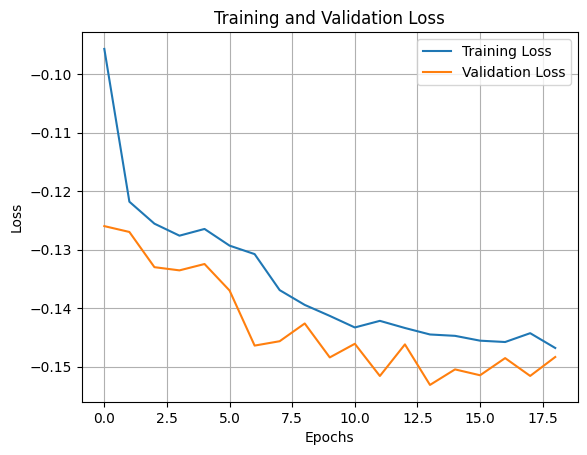

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot training and validation pearson_metric
plt.figure(figsize=(10, 5))
plt.plot(history.history['pearson_metric'], label='Training pearson_metric')
plt.plot(history.history['val_pearson_metric'], label='Validation pearson_metric')
plt.title('Training and Validation pearson_metric')
plt.xlabel('Epochs')
plt.ylabel('pearson_metric')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

3/3 [==============================] - 1s 90ms/step - loss: -0.1518 - pearson_metric: 0.1518
Test Loss: -0.15176591277122498, Test MAE: 0.15176591277122498


In [ ]:
import numpy as np
import tensorflow as tf
from scipy.stats import pearsonr

In [ ]:
def pearson_correlation(y_true, y_pred):
    """
    Calculate Pearson correlation coefficient between y_true and y_pred.

    Parameters:
    - y_true: True target values.
    - y_pred: Predicted target values.

    Returns:
    - Pearson correlation coefficient (r) between y_true and y_pred.
    """
    # Calculate Pearson correlation coefficient
    correlation, _ = pearsonr(np.ravel(y_true), np.ravel(y_pred))
    return correlation

In [ ]:
# Assuming you have already loaded your model and data

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Pearson correlation on the test set
test_corr = pearson_correlation(y_test, y_pred)
print(f"Test Pearson Correlation: {test_corr:.4f}")

3/3 [==============================] - 1s 107ms/step
Test Pearson Correlation: 0.1191


### Testing correlation with mismatched envelopes

In [ ]:
# adadelta 32 repeat
model_path = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Code/Reconstruction/Model/vlaai/adadelta_32epochs_32batch_size_repeat/model.h5"

In [ ]:
# Define and load the pretrained model
model = vlaai()
model.load_weights(model_path)

In [ ]:
# Your feature data (X) and target labels (y)
X = mega_eeg_list  # Your feature matrix (e.g., NumPy array or Pandas DataFrame)
y_true = mega_audio_list # Your target labels (e.g., NumPy array or Pandas Series)

In [ ]:
# Make predictions on the test set
# subject
y_pred = model.predict(X)

29/29 [==============================] - 3s 95ms/step


In [ ]:
# Calculate correct Pearson correlation on the test set
test_corr = pearson_correlation(y_true, y_pred)
print(f"Test Pearson Correlation: {test_corr:.4f}")

Test Pearson Correlation: 0.1408


In [ ]:
rotated_y_true = y_true[1:] + y_true[:1]

In [ ]:
test_corr = pearson_correlation(rotated_y_true, y_pred)
print(f"Test Pearson Correlation: {test_corr:.4f}")

Test Pearson Correlation: 0.1340


In [ ]:
import random

shuffled_y_true = random.sample(y_true, len(y_true))

In [ ]:
test_corr = pearson_correlation(shuffled_y_true, y_true)
print(f"Test Pearson Correlation: {test_corr:.4f}")

Test Pearson Correlation: 0.0392


In [ ]:
test_corr = pearson_correlation(shuffled_y_true, y_pred)
print(f"Test Pearson Correlation: {test_corr:.4f}")

Test Pearson Correlation: 0.1297


Checking for non linear association

